In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


# Device setup for MPS (Metal Performance Shaders)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=1.0),
            A.Affine(
                rotate=(-15, 15),
                translate_percent=(0.1, 0.1),
                scale=(0.8, 1.2),
                shear=10,
                p=0.5
            ),
            A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ])
        
        self.image_augmentation = A.Compose([
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        image = np.array(image)
        mask = np.array(mask)
        
        # Apply transformations
        transformed = self.common_augmentation(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']

        image = self.image_augmentation(image=image)['image']

        # Convert numpy array back to PIL image
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Paths to images and masks
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

# Get image and mask paths
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

# Create transform objects
advanced_transform = AdvancedTransform()
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Using device: mps


/Users/snirtahasa/anaconda3/lib/python3.11/site-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [2]:
# images masks sorting verification

top_img = []
top_mask = []

for i in image_paths[:5]:
    image = i.split("/")[-1]
    top_img.append(image)

for i in mask_paths[:5]:
    mask = i.split("/")[-1]
    top_mask.append(mask)

print(top_img)
print(top_mask)

['cju83yddek68q0850d2x7zfkm.jpg', 'cju2mfjndoz700988b9lc3zeq.jpg', 'cju7cq6su27qv075574dir0r3.jpg', 'cju5g163vd6mt0817uccuga6u.jpg', 'cju6wjm81vgsc0987enk9n3pr.jpg']
['cju83yddek68q0850d2x7zfkm.jpg', 'cju2mfjndoz700988b9lc3zeq.jpg', 'cju7cq6su27qv075574dir0r3.jpg', 'cju5g163vd6mt0817uccuga6u.jpg', 'cju6wjm81vgsc0987enk9n3pr.jpg']


/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images/cju83yddek68q0850d2x7zfkm.jpg
(622, 529)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


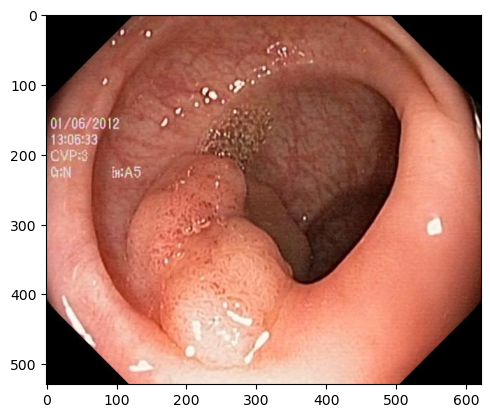

/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks/cju83yddek68q0850d2x7zfkm.jpg
(622, 529)


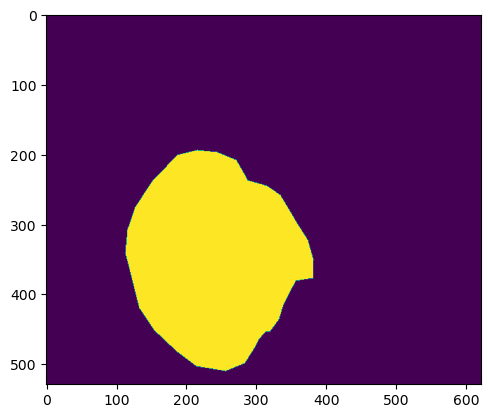

----------------------------------------------------
/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images/cju2mfjndoz700988b9lc3zeq.jpg
(622, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


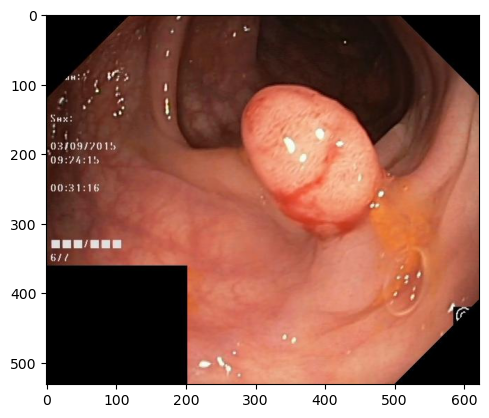

/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks/cju2mfjndoz700988b9lc3zeq.jpg
(622, 531)


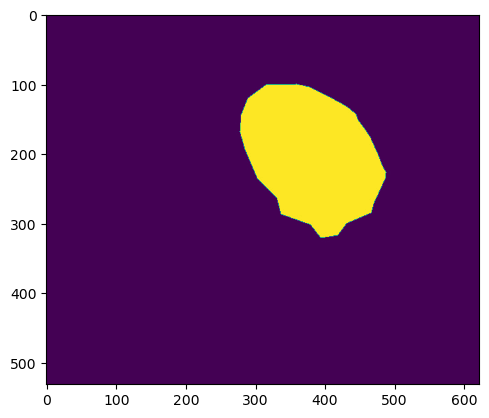

----------------------------------------------------


In [3]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(image_paths[i])
        mask_path = os.path.join(mask_paths[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(image_paths, mask_paths)

In [4]:
def show_single_img(img=None, mask=None, index=None, train=True):
    if index is not None:
        if train:
            img, mask = train_dataset[index]
        else:
            img, mask = val_dataset[index]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Show the image
    axes[0].imshow(img.permute(1, 2, 0), cmap="gray")  # Convert (3, 512, 512) -> (512, 512, 3)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Show the mask
    axes[1].imshow(mask.permute(1, 2, 0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    print(mask.shape)

    plt.show()

---------------Train---------------
torch.Size([1, 256, 256])


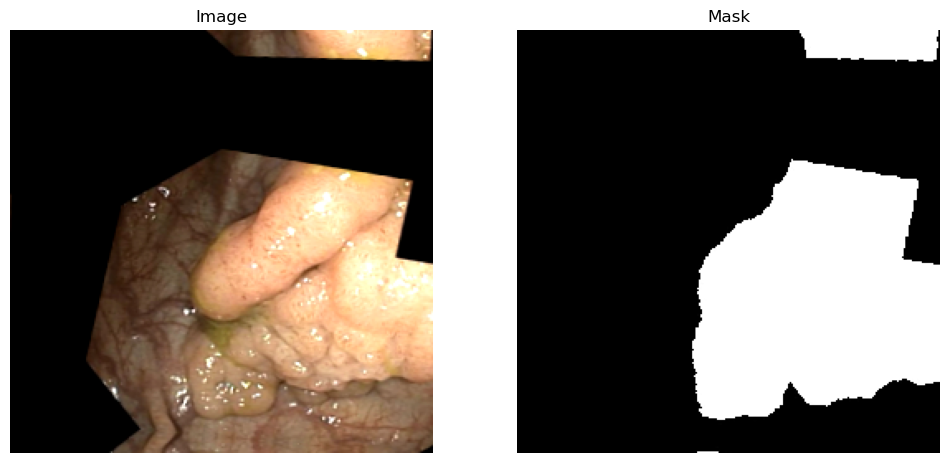

---------------Validation--------------
torch.Size([1, 256, 256])


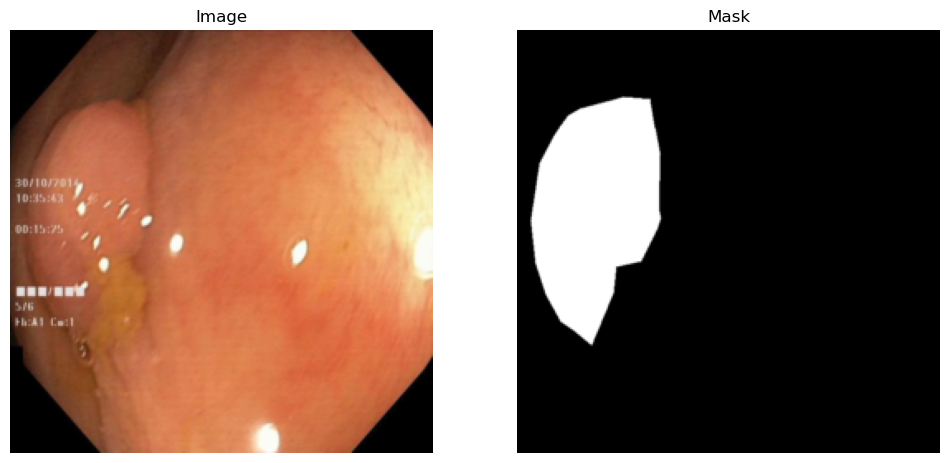

In [5]:
print("---------------Train---------------")
show_single_img(image,mask,index=30,train=True)
print("---------------Validation--------------")
show_single_img(image,mask,index=30,train=False)

### Step 2: Define the U-Net Model

In [7]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=128):
        super(UNet, self).__init__()

        features = init_features
        self.down1 = self.conv_block(in_channels, features)
        self.down2 = self.conv_block(features, features * 2)
        self.down3 = self.conv_block(features * 2, features * 4)
        self.down4 = self.conv_block(features * 4, features * 8)
        self.down5 = self.conv_block(features * 8, features * 16)

        self.up1 = self.up_conv_block(features * 16, features * 8)
        self.up_conv1 = self.conv_block(features * 16, features * 8)
        self.up2 = self.up_conv_block(features * 8, features * 4)
        self.up_conv2 = self.conv_block(features * 8, features * 4)
        self.up3 = self.up_conv_block(features * 4, features * 2)
        self.up_conv3 = self.conv_block(features * 4, features * 2)
        self.up4 = self.up_conv_block(features * 2, features)
        self.up_conv4 = self.conv_block(features * 2, features)
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3) 
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)

# Example usage
# Adjust init_features to control the width of the network
Width_Depth_Adj_model = UNet(in_channels=3, out_channels=1, init_features=64)

### Step 3: Training Loop with Metrics and Plotting

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


Width_Depth_Adj_model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(Width_Depth_Adj_model.parameters(), lr=0.01, momentum=0.9)

def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [10]:
# Training

Explanation of the Adjustments
Depth:

Encoder Path: Added one more downsampling step (down5).
Decoder Path: Corresponding upsampling step (up1) and subsequent concatenations.
Width:

Changed the initial number of filters from 64 to 128 in the conv_block and up_conv_block methods to increase the width of the network. This is controlled via the init_features parameter.
Expected Improvements
Feature Extraction: Increased capacity to capture more detailed and varied features.
Model Performance: Potential improvements in segmentation accuracy and generalization due to richer feature representations.
Considerations
Computational Cost: Increased depth and width mean higher computational requirements. Ensure adequate resources (e.g., GPU memory).
Regularization: Use techniques like dropout and data augmentation to mitigate overfitting with the increased model complexity.

In [11]:
num_epochs = 25
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Width_Depth_Adj_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Width_Depth_Adj_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Width_Depth_Adj_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Width_Depth_Adj_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/25: 100%|█████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch [1/25], Loss: 0.4392
Epoch [1/25], Validation Loss: 0.3803, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/25: 100%|█████████████████████████████| 200/200 [07:01<00:00,  2.11s/it]


Epoch [2/25], Loss: 0.3827
Epoch [2/25], Validation Loss: 0.3383, Validation Dice: 0.0051, Validation IoU: 0.0026


Epoch 3/25: 100%|█████████████████████████████| 200/200 [07:00<00:00,  2.10s/it]


Epoch [3/25], Loss: 0.3720
Epoch [3/25], Validation Loss: 0.3626, Validation Dice: 0.3851, Validation IoU: 0.2759


Epoch 4/25: 100%|█████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch [4/25], Loss: 0.3718
Epoch [4/25], Validation Loss: 0.3267, Validation Dice: 0.0012, Validation IoU: 0.0006


Epoch 5/25: 100%|█████████████████████████████| 200/200 [07:04<00:00,  2.12s/it]


Epoch [5/25], Loss: 0.3691
Epoch [5/25], Validation Loss: 0.3229, Validation Dice: 0.3871, Validation IoU: 0.2763


Epoch 6/25: 100%|█████████████████████████████| 200/200 [07:00<00:00,  2.10s/it]


Epoch [6/25], Loss: 0.3612
Epoch [6/25], Validation Loss: 0.3285, Validation Dice: 0.1886, Validation IoU: 0.1236


Epoch 7/25: 100%|█████████████████████████████| 200/200 [07:07<00:00,  2.14s/it]


Epoch [7/25], Loss: 0.3517
Epoch [7/25], Validation Loss: 0.3698, Validation Dice: 0.4894, Validation IoU: 0.3610


Epoch 8/25: 100%|█████████████████████████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch [8/25], Loss: 0.3534
Epoch [8/25], Validation Loss: 0.3280, Validation Dice: 0.4519, Validation IoU: 0.3267


Epoch 9/25: 100%|█████████████████████████████| 200/200 [07:16<00:00,  2.18s/it]


Epoch [9/25], Loss: 0.3279
Epoch [9/25], Validation Loss: 0.2825, Validation Dice: 0.4482, Validation IoU: 0.3447


Epoch 10/25: 100%|████████████████████████████| 200/200 [07:16<00:00,  2.18s/it]


Epoch [10/25], Loss: 0.3220
Epoch [10/25], Validation Loss: 0.3048, Validation Dice: 0.2135, Validation IoU: 0.1554


Epoch 11/25: 100%|████████████████████████████| 200/200 [07:17<00:00,  2.19s/it]


Epoch [11/25], Loss: 0.3151
Epoch [11/25], Validation Loss: 0.2551, Validation Dice: 0.5987, Validation IoU: 0.4807


Epoch 12/25: 100%|████████████████████████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch [12/25], Loss: 0.2977
Epoch [12/25], Validation Loss: 0.2546, Validation Dice: 0.5012, Validation IoU: 0.4004


Epoch 13/25: 100%|████████████████████████████| 200/200 [07:09<00:00,  2.15s/it]


Epoch [13/25], Loss: 0.2886
Epoch [13/25], Validation Loss: 0.2344, Validation Dice: 0.6031, Validation IoU: 0.4993


Epoch 14/25: 100%|████████████████████████████| 200/200 [07:06<00:00,  2.13s/it]


Epoch [14/25], Loss: 0.2795
Epoch [14/25], Validation Loss: 0.2301, Validation Dice: 0.5768, Validation IoU: 0.4639


Epoch 15/25: 100%|████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch [15/25], Loss: 0.2709
Epoch [15/25], Validation Loss: 0.2251, Validation Dice: 0.6467, Validation IoU: 0.5280


Epoch 16/25: 100%|████████████████████████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch [16/25], Loss: 0.2619
Epoch [16/25], Validation Loss: 0.2118, Validation Dice: 0.7020, Validation IoU: 0.5859


Epoch 17/25: 100%|████████████████████████████| 200/200 [07:09<00:00,  2.15s/it]


Epoch [17/25], Loss: 0.2549
Epoch [17/25], Validation Loss: 0.2107, Validation Dice: 0.7170, Validation IoU: 0.6002


Epoch 18/25: 100%|████████████████████████████| 200/200 [07:15<00:00,  2.18s/it]


Epoch [18/25], Loss: 0.2577
Epoch [18/25], Validation Loss: 0.2477, Validation Dice: 0.6733, Validation IoU: 0.5509


Epoch 19/25: 100%|████████████████████████████| 200/200 [07:13<00:00,  2.17s/it]


Epoch [19/25], Loss: 0.2442
Epoch [19/25], Validation Loss: 0.2004, Validation Dice: 0.7118, Validation IoU: 0.6061


Epoch 20/25: 100%|████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch [20/25], Loss: 0.2433
Epoch [20/25], Validation Loss: 0.1976, Validation Dice: 0.7396, Validation IoU: 0.6274


Epoch 21/25: 100%|████████████████████████████| 200/200 [07:07<00:00,  2.14s/it]


Epoch [21/25], Loss: 0.2320
Epoch [21/25], Validation Loss: 0.1926, Validation Dice: 0.7197, Validation IoU: 0.6094


Epoch 22/25: 100%|████████████████████████████| 200/200 [07:06<00:00,  2.13s/it]


Epoch [22/25], Loss: 0.2377
Epoch [22/25], Validation Loss: 0.1949, Validation Dice: 0.6991, Validation IoU: 0.5923


Epoch 23/25: 100%|████████████████████████████| 200/200 [07:08<00:00,  2.14s/it]


Epoch [23/25], Loss: 0.2427
Epoch [23/25], Validation Loss: 0.1779, Validation Dice: 0.7541, Validation IoU: 0.6452


Epoch 24/25: 100%|████████████████████████████| 200/200 [07:10<00:00,  2.15s/it]


Epoch [24/25], Loss: 0.2286
Epoch [24/25], Validation Loss: 0.1939, Validation Dice: 0.7381, Validation IoU: 0.6245


Epoch 25/25: 100%|████████████████████████████| 200/200 [07:05<00:00,  2.13s/it]


Epoch [25/25], Loss: 0.2322
Epoch [25/25], Validation Loss: 0.1910, Validation Dice: 0.7162, Validation IoU: 0.6059


# Unet Width and Depth Adjustments - Data Augmention - Non Advanced

In [23]:
# Device setup for MPS (Metal Performance Shaders)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) backend is available.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available, using CPU.")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-15, 15)),
            transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        ])
        
        self.image_augmentation = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.common_augmentation(image)
        
        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.common_augmentation(mask)

        image = self.image_augmentation(image)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Get image and mask paths
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Create the advanced transform object for training
advanced_transform = AdvancedTransform()

# Create the simple transform object for validation
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

MPS (Metal Performance Shaders) backend is available.


In [24]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=128):
        super(UNet, self).__init__()

        features = init_features
        self.down1 = self.conv_block(in_channels, features)
        self.down2 = self.conv_block(features, features * 2)
        self.down3 = self.conv_block(features * 2, features * 4)
        self.down4 = self.conv_block(features * 4, features * 8)
        self.down5 = self.conv_block(features * 8, features * 16)

        self.up1 = self.up_conv_block(features * 16, features * 8)
        self.up_conv1 = self.conv_block(features * 16, features * 8)
        self.up2 = self.up_conv_block(features * 8, features * 4)
        self.up_conv2 = self.conv_block(features * 8, features * 4)
        self.up3 = self.up_conv_block(features * 4, features * 2)
        self.up_conv3 = self.conv_block(features * 4, features * 2)
        self.up4 = self.up_conv_block(features * 2, features)
        self.up_conv4 = self.conv_block(features * 2, features)
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)

In [25]:
# Adjust init_features to control the width of the network
Width_Depth_Aug_model = UNet(in_channels=3, out_channels=1, init_features=128).to(device)

In [26]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

criterion = nn.BCELoss()
optimizer = optim.SGD(Width_Depth_Aug_model.parameters(), lr=0.01, momentum=0.9)

def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [27]:
num_epochs = 25
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Width_Depth_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Width_Depth_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Width_Depth_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Width_Depth_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/25: 100%|███████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


Epoch [1/25], Loss: 0.5346
Epoch [1/25], Validation Loss: 0.4092, Validation Dice: 0.1035, Validation IoU: 0.0657


Epoch 2/25: 100%|███████████████████████████████| 50/50 [07:24<00:00,  8.89s/it]


Epoch [2/25], Loss: 0.4092
Epoch [2/25], Validation Loss: 0.3632, Validation Dice: 0.1879, Validation IoU: 0.1256


Epoch 3/25: 100%|███████████████████████████████| 50/50 [07:26<00:00,  8.92s/it]


Epoch [3/25], Loss: 0.3921
Epoch [3/25], Validation Loss: 0.3479, Validation Dice: 0.0003, Validation IoU: 0.0001


Epoch 4/25: 100%|███████████████████████████████| 50/50 [07:03<00:00,  8.48s/it]


Epoch [4/25], Loss: 0.3813
Epoch [4/25], Validation Loss: 0.3556, Validation Dice: 0.0008, Validation IoU: 0.0004


Epoch 5/25: 100%|███████████████████████████████| 50/50 [06:50<00:00,  8.21s/it]


Epoch [5/25], Loss: 0.3686
Epoch [5/25], Validation Loss: 0.3447, Validation Dice: 0.2179, Validation IoU: 0.1415


Epoch 6/25: 100%|███████████████████████████████| 50/50 [06:50<00:00,  8.21s/it]


Epoch [6/25], Loss: 0.3643
Epoch [6/25], Validation Loss: 0.3584, Validation Dice: 0.3980, Validation IoU: 0.2861


Epoch 7/25: 100%|███████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [7/25], Loss: 0.3569
Epoch [7/25], Validation Loss: 0.3533, Validation Dice: 0.1547, Validation IoU: 0.0973


Epoch 8/25: 100%|███████████████████████████████| 50/50 [06:51<00:00,  8.23s/it]


Epoch [8/25], Loss: 0.3541
Epoch [8/25], Validation Loss: 0.3632, Validation Dice: 0.0205, Validation IoU: 0.0116


Epoch 9/25: 100%|███████████████████████████████| 50/50 [06:49<00:00,  8.20s/it]


Epoch [9/25], Loss: 0.3466
Epoch [9/25], Validation Loss: 0.3720, Validation Dice: 0.4768, Validation IoU: 0.3460


Epoch 10/25: 100%|██████████████████████████████| 50/50 [06:48<00:00,  8.18s/it]


Epoch [10/25], Loss: 0.3383
Epoch [10/25], Validation Loss: 0.3234, Validation Dice: 0.3376, Validation IoU: 0.2348


Epoch 11/25: 100%|██████████████████████████████| 50/50 [06:55<00:00,  8.31s/it]


Epoch [11/25], Loss: 0.3367
Epoch [11/25], Validation Loss: 0.3232, Validation Dice: 0.2442, Validation IoU: 0.1599


Epoch 12/25: 100%|██████████████████████████████| 50/50 [07:10<00:00,  8.61s/it]


Epoch [12/25], Loss: 0.3306
Epoch [12/25], Validation Loss: 0.3148, Validation Dice: 0.1335, Validation IoU: 0.0813


Epoch 13/25: 100%|██████████████████████████████| 50/50 [07:13<00:00,  8.67s/it]


Epoch [13/25], Loss: 0.3158
Epoch [13/25], Validation Loss: 0.2879, Validation Dice: 0.4867, Validation IoU: 0.3612


Epoch 14/25: 100%|██████████████████████████████| 50/50 [07:17<00:00,  8.75s/it]


Epoch [14/25], Loss: 0.3080
Epoch [14/25], Validation Loss: 0.4054, Validation Dice: 0.4656, Validation IoU: 0.3359


Epoch 15/25: 100%|██████████████████████████████| 50/50 [07:13<00:00,  8.67s/it]


Epoch [15/25], Loss: 0.3004
Epoch [15/25], Validation Loss: 0.2786, Validation Dice: 0.5021, Validation IoU: 0.3726


Epoch 16/25: 100%|██████████████████████████████| 50/50 [07:05<00:00,  8.52s/it]


Epoch [16/25], Loss: 0.2916
Epoch [16/25], Validation Loss: 0.2739, Validation Dice: 0.5196, Validation IoU: 0.3963


Epoch 17/25: 100%|██████████████████████████████| 50/50 [07:19<00:00,  8.79s/it]


Epoch [17/25], Loss: 0.2797
Epoch [17/25], Validation Loss: 0.3176, Validation Dice: 0.3644, Validation IoU: 0.2599


Epoch 18/25: 100%|██████████████████████████████| 50/50 [06:59<00:00,  8.40s/it]


Epoch [18/25], Loss: 0.2612
Epoch [18/25], Validation Loss: 0.3128, Validation Dice: 0.2046, Validation IoU: 0.1392


Epoch 19/25: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Epoch [19/25], Loss: 0.2525
Epoch [19/25], Validation Loss: 0.2609, Validation Dice: 0.5576, Validation IoU: 0.4359


Epoch 20/25: 100%|██████████████████████████████| 50/50 [06:57<00:00,  8.34s/it]


Epoch [20/25], Loss: 0.2433
Epoch [20/25], Validation Loss: 0.2425, Validation Dice: 0.6117, Validation IoU: 0.4902


Epoch 21/25: 100%|██████████████████████████████| 50/50 [07:06<00:00,  8.54s/it]


Epoch [21/25], Loss: 0.2278
Epoch [21/25], Validation Loss: 0.2252, Validation Dice: 0.6637, Validation IoU: 0.5442


Epoch 22/25: 100%|██████████████████████████████| 50/50 [07:06<00:00,  8.53s/it]


Epoch [22/25], Loss: 0.2217
Epoch [22/25], Validation Loss: 0.2520, Validation Dice: 0.5710, Validation IoU: 0.4472


Epoch 23/25: 100%|██████████████████████████████| 50/50 [07:02<00:00,  8.45s/it]


Epoch [23/25], Loss: 0.2237
Epoch [23/25], Validation Loss: 0.2565, Validation Dice: 0.4643, Validation IoU: 0.3714


Epoch 24/25: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Epoch [24/25], Loss: 0.2103
Epoch [24/25], Validation Loss: 0.2111, Validation Dice: 0.6416, Validation IoU: 0.5342


Epoch 25/25: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Epoch [25/25], Loss: 0.2072
Epoch [25/25], Validation Loss: 0.2205, Validation Dice: 0.6374, Validation IoU: 0.5281


In [28]:
num_epochs = 25
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Width_Depth_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Width_Depth_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Width_Depth_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Width_Depth_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/25: 100%|███████████████████████████████| 50/50 [06:56<00:00,  8.34s/it]


Epoch [1/25], Loss: 0.2027
Epoch [1/25], Validation Loss: 0.2495, Validation Dice: 0.6930, Validation IoU: 0.5684


Epoch 2/25: 100%|███████████████████████████████| 50/50 [07:01<00:00,  8.43s/it]


Epoch [2/25], Loss: 0.1935
Epoch [2/25], Validation Loss: 0.2290, Validation Dice: 0.6095, Validation IoU: 0.5023


Epoch 3/25: 100%|███████████████████████████████| 50/50 [06:55<00:00,  8.30s/it]


Epoch [3/25], Loss: 0.1889
Epoch [3/25], Validation Loss: 0.2154, Validation Dice: 0.6739, Validation IoU: 0.5610


Epoch 4/25: 100%|███████████████████████████████| 50/50 [06:46<00:00,  8.13s/it]


Epoch [4/25], Loss: 0.1813
Epoch [4/25], Validation Loss: 0.2278, Validation Dice: 0.6920, Validation IoU: 0.5781


Epoch 5/25: 100%|███████████████████████████████| 50/50 [06:45<00:00,  8.12s/it]


Epoch [5/25], Loss: 0.1866
Epoch [5/25], Validation Loss: 0.1871, Validation Dice: 0.7260, Validation IoU: 0.6195


Epoch 6/25: 100%|███████████████████████████████| 50/50 [07:03<00:00,  8.47s/it]


Epoch [6/25], Loss: 0.1757
Epoch [6/25], Validation Loss: 0.2011, Validation Dice: 0.6298, Validation IoU: 0.5297


Epoch 7/25: 100%|███████████████████████████████| 50/50 [06:57<00:00,  8.36s/it]


Epoch [7/25], Loss: 0.1778
Epoch [7/25], Validation Loss: 0.1674, Validation Dice: 0.7524, Validation IoU: 0.6483


Epoch 8/25: 100%|███████████████████████████████| 50/50 [07:11<00:00,  8.63s/it]


Epoch [8/25], Loss: 0.1684
Epoch [8/25], Validation Loss: 0.2052, Validation Dice: 0.6882, Validation IoU: 0.5800


Epoch 9/25: 100%|███████████████████████████████| 50/50 [06:59<00:00,  8.39s/it]


Epoch [9/25], Loss: 0.1676
Epoch [9/25], Validation Loss: 0.2074, Validation Dice: 0.6994, Validation IoU: 0.5885


Epoch 10/25: 100%|██████████████████████████████| 50/50 [06:57<00:00,  8.35s/it]


Epoch [10/25], Loss: 0.1706
Epoch [10/25], Validation Loss: 0.2072, Validation Dice: 0.7092, Validation IoU: 0.5981


Epoch 11/25: 100%|██████████████████████████████| 50/50 [06:48<00:00,  8.16s/it]


Epoch [11/25], Loss: 0.1577
Epoch [11/25], Validation Loss: 0.3202, Validation Dice: 0.6239, Validation IoU: 0.4957


Epoch 12/25: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Epoch [12/25], Loss: 0.1553
Epoch [12/25], Validation Loss: 0.2549, Validation Dice: 0.6838, Validation IoU: 0.5694


Epoch 13/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [13/25], Loss: 0.1608
Epoch [13/25], Validation Loss: 0.1793, Validation Dice: 0.7434, Validation IoU: 0.6400


Epoch 14/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [14/25], Loss: 0.1483
Epoch [14/25], Validation Loss: 0.1653, Validation Dice: 0.7546, Validation IoU: 0.6574


Epoch 15/25: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Epoch [15/25], Loss: 0.1489
Epoch [15/25], Validation Loss: 0.1568, Validation Dice: 0.7781, Validation IoU: 0.6779


Epoch 16/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [16/25], Loss: 0.1444
Epoch [16/25], Validation Loss: 0.1656, Validation Dice: 0.7772, Validation IoU: 0.6721


Epoch 17/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [17/25], Loss: 0.1412
Epoch [17/25], Validation Loss: 0.1618, Validation Dice: 0.7482, Validation IoU: 0.6515


Epoch 18/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [18/25], Loss: 0.1441
Epoch [18/25], Validation Loss: 0.1767, Validation Dice: 0.7544, Validation IoU: 0.6501


Epoch 19/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [19/25], Loss: 0.1362
Epoch [19/25], Validation Loss: 0.1630, Validation Dice: 0.7414, Validation IoU: 0.6551


Epoch 20/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [20/25], Loss: 0.1406
Epoch [20/25], Validation Loss: 0.1578, Validation Dice: 0.7844, Validation IoU: 0.6941


Epoch 21/25: 100%|██████████████████████████████| 50/50 [06:41<00:00,  8.04s/it]


Epoch [21/25], Loss: 0.1375
Epoch [21/25], Validation Loss: 0.1557, Validation Dice: 0.7718, Validation IoU: 0.6769


Epoch 22/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [22/25], Loss: 0.1293
Epoch [22/25], Validation Loss: 0.2132, Validation Dice: 0.7159, Validation IoU: 0.6078


Epoch 23/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [23/25], Loss: 0.1269
Epoch [23/25], Validation Loss: 0.1750, Validation Dice: 0.7738, Validation IoU: 0.6702


Epoch 24/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [24/25], Loss: 0.1207
Epoch [24/25], Validation Loss: 0.1621, Validation Dice: 0.7942, Validation IoU: 0.6969


Epoch 25/25: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.06s/it]


Epoch [25/25], Loss: 0.1252
Epoch [25/25], Validation Loss: 0.1862, Validation Dice: 0.7612, Validation IoU: 0.6543


In [29]:
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Width_Depth_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Width_Depth_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Width_Depth_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Width_Depth_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/50: 100%|███████████████████████████████| 50/50 [06:54<00:00,  8.28s/it]


Epoch [1/50], Loss: 0.1223
Epoch [1/50], Validation Loss: 0.1516, Validation Dice: 0.8022, Validation IoU: 0.7062


Epoch 2/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.26s/it]


Epoch [2/50], Loss: 0.1263
Epoch [2/50], Validation Loss: 0.1831, Validation Dice: 0.7292, Validation IoU: 0.6401


Epoch 3/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.26s/it]


Epoch [3/50], Loss: 0.1220
Epoch [3/50], Validation Loss: 0.1558, Validation Dice: 0.7872, Validation IoU: 0.6893


Epoch 4/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch [4/50], Loss: 0.1198
Epoch [4/50], Validation Loss: 0.1553, Validation Dice: 0.7868, Validation IoU: 0.6924


Epoch 5/50: 100%|███████████████████████████████| 50/50 [06:53<00:00,  8.26s/it]


Epoch [5/50], Loss: 0.1059
Epoch [5/50], Validation Loss: 0.1605, Validation Dice: 0.7745, Validation IoU: 0.6734


Epoch 6/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch [6/50], Loss: 0.1126
Epoch [6/50], Validation Loss: 0.1557, Validation Dice: 0.7884, Validation IoU: 0.6940


Epoch 7/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch [7/50], Loss: 0.1129
Epoch [7/50], Validation Loss: 0.1494, Validation Dice: 0.7947, Validation IoU: 0.7078


Epoch 8/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch [8/50], Loss: 0.1037
Epoch [8/50], Validation Loss: 0.1655, Validation Dice: 0.7807, Validation IoU: 0.6830


Epoch 9/50: 100%|███████████████████████████████| 50/50 [06:52<00:00,  8.26s/it]


Epoch [9/50], Loss: 0.1067
Epoch [9/50], Validation Loss: 0.1612, Validation Dice: 0.7536, Validation IoU: 0.6675


Epoch 10/50: 100%|██████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


Epoch [10/50], Loss: 0.1057
Epoch [10/50], Validation Loss: 0.1487, Validation Dice: 0.8137, Validation IoU: 0.7240


Epoch 11/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.26s/it]


Epoch [11/50], Loss: 0.1000
Epoch [11/50], Validation Loss: 0.1570, Validation Dice: 0.7663, Validation IoU: 0.6708


Epoch 12/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [12/50], Loss: 0.1073
Epoch [12/50], Validation Loss: 0.1528, Validation Dice: 0.8044, Validation IoU: 0.7075


Epoch 13/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [13/50], Loss: 0.1025
Epoch [13/50], Validation Loss: 0.1533, Validation Dice: 0.8137, Validation IoU: 0.7244


Epoch 14/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [14/50], Loss: 0.0993
Epoch [14/50], Validation Loss: 0.1495, Validation Dice: 0.7921, Validation IoU: 0.6966


Epoch 15/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [15/50], Loss: 0.0948
Epoch [15/50], Validation Loss: 0.1470, Validation Dice: 0.8097, Validation IoU: 0.7186


Epoch 16/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [16/50], Loss: 0.0955
Epoch [16/50], Validation Loss: 0.1706, Validation Dice: 0.7520, Validation IoU: 0.6567


Epoch 17/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [17/50], Loss: 0.1006
Epoch [17/50], Validation Loss: 0.1595, Validation Dice: 0.7810, Validation IoU: 0.6900


Epoch 18/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [18/50], Loss: 0.0960
Epoch [18/50], Validation Loss: 0.1641, Validation Dice: 0.7947, Validation IoU: 0.7030


Epoch 19/50: 100%|██████████████████████████████| 50/50 [06:54<00:00,  8.28s/it]


Epoch [19/50], Loss: 0.0953
Epoch [19/50], Validation Loss: 0.2217, Validation Dice: 0.7451, Validation IoU: 0.6356


Epoch 20/50: 100%|██████████████████████████████| 50/50 [06:52<00:00,  8.26s/it]


Epoch [20/50], Loss: 0.0942
Epoch [20/50], Validation Loss: 0.1588, Validation Dice: 0.7846, Validation IoU: 0.6957


Epoch 21/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [21/50], Loss: 0.0932
Epoch [21/50], Validation Loss: 0.1489, Validation Dice: 0.7898, Validation IoU: 0.6967


Epoch 22/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [22/50], Loss: 0.0818
Epoch [22/50], Validation Loss: 0.1390, Validation Dice: 0.7975, Validation IoU: 0.7059


Epoch 23/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.28s/it]


Epoch [23/50], Loss: 0.0817
Epoch [23/50], Validation Loss: 0.1547, Validation Dice: 0.7682, Validation IoU: 0.6726


Epoch 24/50: 100%|██████████████████████████████| 50/50 [06:53<00:00,  8.27s/it]


Epoch [24/50], Loss: 0.0828
Epoch [24/50], Validation Loss: 0.1521, Validation Dice: 0.7994, Validation IoU: 0.7042


Epoch 25/50: 100%|██████████████████████████████| 50/50 [06:43<00:00,  8.08s/it]


Epoch [25/50], Loss: 0.0812
Epoch [25/50], Validation Loss: 0.1700, Validation Dice: 0.7842, Validation IoU: 0.6889


Epoch 26/50: 100%|██████████████████████████████| 50/50 [06:41<00:00,  8.04s/it]


Epoch [26/50], Loss: 0.0820
Epoch [26/50], Validation Loss: 0.1700, Validation Dice: 0.7927, Validation IoU: 0.7025


Epoch 27/50: 100%|██████████████████████████████| 50/50 [06:41<00:00,  8.03s/it]


Epoch [27/50], Loss: 0.0847
Epoch [27/50], Validation Loss: 0.1616, Validation Dice: 0.7594, Validation IoU: 0.6765


Epoch 28/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [28/50], Loss: 0.0816
Epoch [28/50], Validation Loss: 0.1750, Validation Dice: 0.8040, Validation IoU: 0.7159


Epoch 29/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [29/50], Loss: 0.0769
Epoch [29/50], Validation Loss: 0.1618, Validation Dice: 0.7577, Validation IoU: 0.6691


Epoch 30/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [30/50], Loss: 0.0809
Epoch [30/50], Validation Loss: 0.1489, Validation Dice: 0.7842, Validation IoU: 0.6942


Epoch 31/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [31/50], Loss: 0.0769
Epoch [31/50], Validation Loss: 0.1774, Validation Dice: 0.7639, Validation IoU: 0.6714


Epoch 32/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [32/50], Loss: 0.0772
Epoch [32/50], Validation Loss: 0.1527, Validation Dice: 0.8049, Validation IoU: 0.7159


Epoch 33/50: 100%|██████████████████████████████| 50/50 [06:41<00:00,  8.04s/it]


Epoch [33/50], Loss: 0.0775
Epoch [33/50], Validation Loss: 0.1592, Validation Dice: 0.7713, Validation IoU: 0.6839


Epoch 34/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [34/50], Loss: 0.0676
Epoch [34/50], Validation Loss: 0.1968, Validation Dice: 0.7697, Validation IoU: 0.6709


Epoch 35/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [35/50], Loss: 0.0689
Epoch [35/50], Validation Loss: 0.1596, Validation Dice: 0.8120, Validation IoU: 0.7233


Epoch 36/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [36/50], Loss: 0.0746
Epoch [36/50], Validation Loss: 0.1483, Validation Dice: 0.8001, Validation IoU: 0.7059


Epoch 37/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [37/50], Loss: 0.0743
Epoch [37/50], Validation Loss: 0.1800, Validation Dice: 0.7890, Validation IoU: 0.6967


Epoch 38/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [38/50], Loss: 0.0637
Epoch [38/50], Validation Loss: 0.1559, Validation Dice: 0.8180, Validation IoU: 0.7270


Epoch 39/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [39/50], Loss: 0.0649
Epoch [39/50], Validation Loss: 0.1689, Validation Dice: 0.7872, Validation IoU: 0.7014


Epoch 40/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [40/50], Loss: 0.0664
Epoch [40/50], Validation Loss: 0.1494, Validation Dice: 0.8054, Validation IoU: 0.7181


Epoch 41/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [41/50], Loss: 0.0644
Epoch [41/50], Validation Loss: 0.1682, Validation Dice: 0.7971, Validation IoU: 0.7035


Epoch 42/50: 100%|██████████████████████████████| 50/50 [06:41<00:00,  8.04s/it]


Epoch [42/50], Loss: 0.0666
Epoch [42/50], Validation Loss: 0.1519, Validation Dice: 0.8157, Validation IoU: 0.7261


Epoch 43/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [43/50], Loss: 0.0658
Epoch [43/50], Validation Loss: 0.1660, Validation Dice: 0.8054, Validation IoU: 0.7184


Epoch 44/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [44/50], Loss: 0.0713
Epoch [44/50], Validation Loss: 0.1768, Validation Dice: 0.8029, Validation IoU: 0.7116


Epoch 45/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [45/50], Loss: 0.0595
Epoch [45/50], Validation Loss: 0.1859, Validation Dice: 0.7925, Validation IoU: 0.7037


Epoch 46/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [46/50], Loss: 0.0619
Epoch [46/50], Validation Loss: 0.1449, Validation Dice: 0.8040, Validation IoU: 0.7192


Epoch 47/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [47/50], Loss: 0.0622
Epoch [47/50], Validation Loss: 0.1569, Validation Dice: 0.8150, Validation IoU: 0.7246


Epoch 48/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [48/50], Loss: 0.0657
Epoch [48/50], Validation Loss: 0.1623, Validation Dice: 0.7746, Validation IoU: 0.6847


Epoch 49/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.04s/it]


Epoch [49/50], Loss: 0.0625
Epoch [49/50], Validation Loss: 0.1971, Validation Dice: 0.7813, Validation IoU: 0.6939


Epoch 50/50: 100%|██████████████████████████████| 50/50 [06:42<00:00,  8.05s/it]


Epoch [50/50], Loss: 0.0571
Epoch [50/50], Validation Loss: 0.1582, Validation Dice: 0.8123, Validation IoU: 0.7219


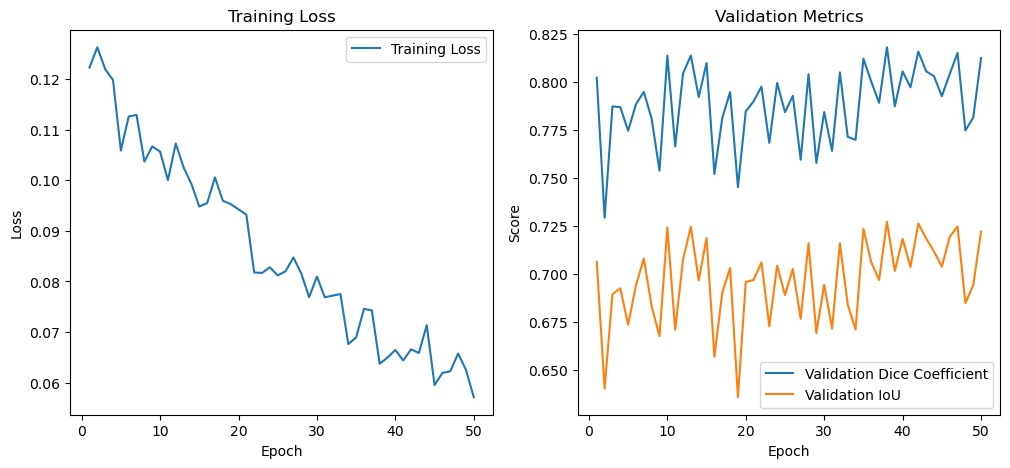

In [31]:
# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 100 + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 50 + 1), val_dice_scores, label='Validation Dice Coefficient')
plt.plot(range(1, 50 + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Metrics')

plt.show()

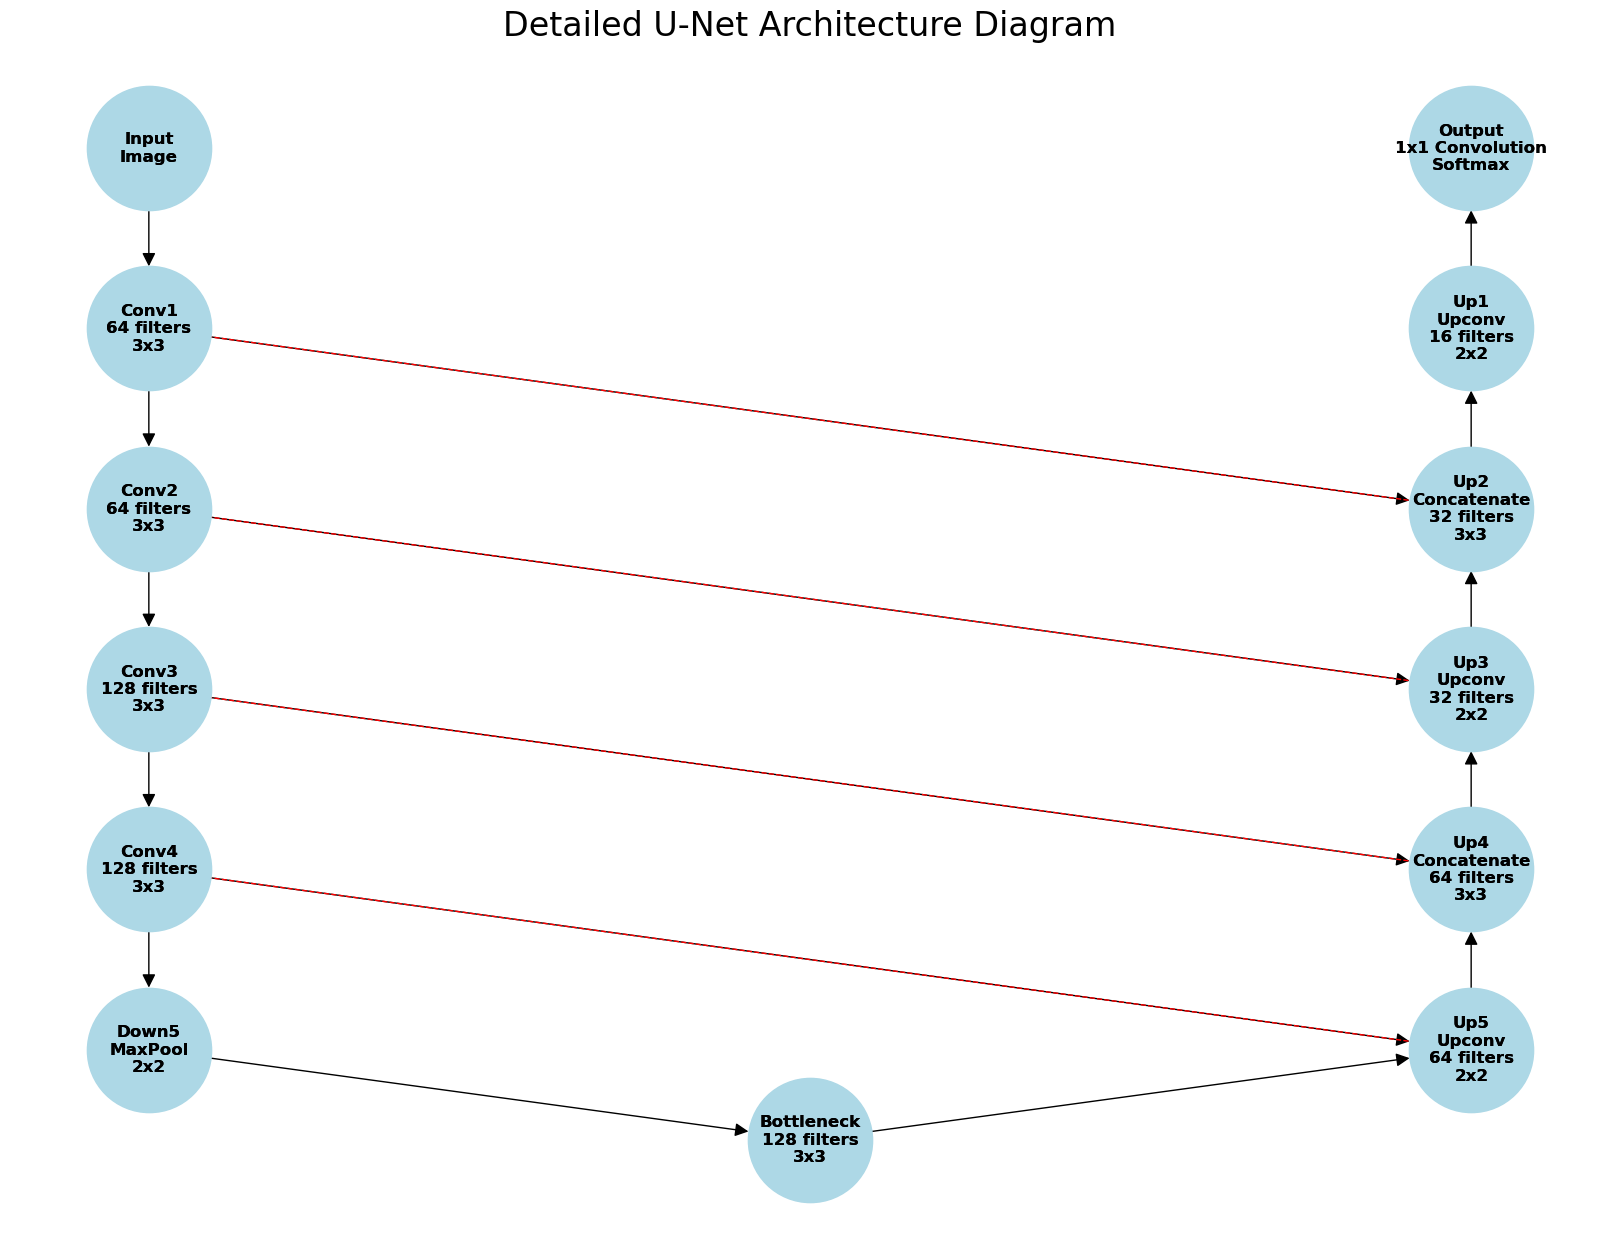

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new directed graph
G = nx.DiGraph()

# Define the nodes with detailed descriptions
nodes = {
    "Input": "Input\nImage",
    "Conv1": "Conv1\n64 filters\n3x3",
    "Conv2": "Conv2\n64 filters\n3x3",
    "Conv3": "Conv3\n128 filters\n3x3",
    "Conv4": "Conv4\n128 filters\n3x3",
    "Down5": "Down5\nMaxPool\n2x2",
    "Bottleneck": "Bottleneck\n128 filters\n3x3",
    "Up5": "Up5\nUpconv\n64 filters\n2x2",
    "Up4": "Up4\nConcatenate\n64 filters\n3x3",
    "Up3": "Up3\nUpconv\n32 filters\n2x2",
    "Up2": "Up2\nConcatenate\n32 filters\n3x3",
    "Up1": "Up1\nUpconv\n16 filters\n2x2",
    "Output": "Output\n1x1 Convolution\nSoftmax"
}

# Define the edges between nodes (including skip connections)
edges = [
    ("Input", "Conv1"),
    ("Conv1", "Conv2"),
    ("Conv2", "Conv3"),
    ("Conv3", "Conv4"),
    ("Conv4", "Down5"),
    ("Down5", "Bottleneck"),
    ("Bottleneck", "Up5"),
    ("Up5", "Up4"),
    ("Up4", "Up3"),
    ("Up3", "Up2"),
    ("Up2", "Up1"),
    ("Up1", "Output"),
    # Skip connections
    ("Conv4", "Up5"),
    ("Conv3", "Up4"),
    ("Conv2", "Up3"),
    ("Conv1", "Up2")
]

# Add nodes and edges to the graph
G.add_edges_from(edges)

# Define positions for nodes to create a U-Net-like layout with skip connections
pos = {
    "Input": (0, 5),
    "Conv1": (0, 4),
    "Conv2": (0, 3),
    "Conv3": (0, 2),
    "Conv4": (0, 1),
    "Down5": (0, 0),
    "Bottleneck": (1, -0.5),  # Bottleneck closer to center
    "Up5": (2, 0),
    "Up4": (2, 1),
    "Up3": (2, 2),
    "Up2": (2, 3),
    "Up1": (2, 4),
    "Output": (2, 5)
}

# Draw the nodes and edges with detailed labels
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, labels=nodes, node_size=8000, node_color='lightblue', font_size=12, font_weight='bold', arrows=True, arrowsize=20, edge_color='black')

# Draw skip connection edges separately with dashed lines
skip_edges = [
    ("Conv4", "Up5"),
    ("Conv3", "Up4"),
    ("Conv2", "Up3"),
    ("Conv1", "Up2")
]
nx.draw_networkx_edges(G, pos, edgelist=skip_edges, style='dashed', edge_color='red', arrows=False)

# Optionally, draw the labels separately to avoid overlap
nx.draw_networkx_labels(G, pos, labels=nodes, font_size=12, font_weight='bold')

# Increase the title size
plt.title("Detailed U-Net Architecture Diagram", fontsize=24)
plt.show()
